In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils.make_pairs import make_pairs

## Prepare Data For Siamese Network

Load Data and Labels

In [23]:
train_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_train'
val_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_val'

file_paths_train = tf.data.Dataset.list_files(train_data_dir + '/*.jpg')
file_paths_val = tf.data.Dataset.list_files(val_data_dir + '/*.jpg')

# Define the function to extract the label from the file name
# works for my specific directory path...
def extract_label(file_path):
    label = tf.strings.split(file_path, '_')
    label = tf.strings.split(label, '\\')
    return int(label[2][1])

def read_and_decode(file_path):
    label = extract_label(file_path)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

print("[INFO] loading data...")

dataset_train = [read_and_decode(file) for file in file_paths_train]
dataset_val = [read_and_decode(file) for file in file_paths_val]

[INFO] loading data...


Visualize Training Data

IMAGE SHAPE:  (128, 64, 3)


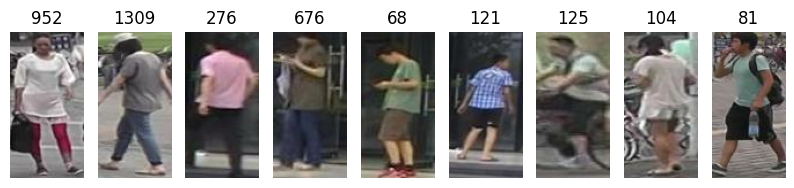

In [24]:
plt.figure(figsize=(10, 10))
subplot_pos = 1

for image, label in dataset_train[:9]:
  ax = plt.subplot(1, 9, subplot_pos)
  subplot_pos += 1
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

print("IMAGE SHAPE: ", image.shape)

In [25]:
labels = [label for image, label in dataset_train]
unique_labels = np.unique(np.array(labels))

idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]

for unique_label in unique_labels:
    idxs = np.where(labels == unique_label)[0]
    print(f"{unique_label} => {len(idxs)} : {idxs}")

2 => 46 : [  288  1743  2165  2355  3065  3466  3954  4114  4115  4278  4551  4561
  4669  4715  4763  4792  4963  5030  5547  5823  5875  6541  6920  7127
  7512  7746  7824  8039  8182  8860  8968  9129  9204  9330  9797 10134
 10218 10224 10544 11257 11360 11695 11776 12078 12243 12392]
7 => 7 : [  627  1476  2012  6397  6532  7925 11139]
10 => 11 : [  296   609  2595  6002  6410 11386 11416 11527 11735 12236 12766]
11 => 15 : [ 3380  4548  4579  5024  5660  6489  7042  7291  7538  8111  8782 10074
 10432 11779 11849]
12 => 6 : [  548  1608  3415  8311 11536 12876]
20 => 6 : [ 3870  6896  7650 10154 10726 12397]
22 => 59 : [  137   232   263   408   846   885  2383  2642  2646  2668  3279  3306
  3549  3625  3670  4150  4281  4312  4654  4717  4902  5289  5295  5425
  5554  5704  5836  6379  6512  6680  6860  6899  7147  7346  7539  7785
  7892  8515  8724  8790  8886  9414  9802  9943 10041 10470 10617 10715
 10886 10949 11018 11311 11326 11734 12107 12206 12271 12388 12795]
23 => 

Make Pairs

In [26]:
train_pair_x, train_pair_y = make_pairs(dataset_train)
val_pair_x, val_pair_y = make_pairs(dataset_val)

c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


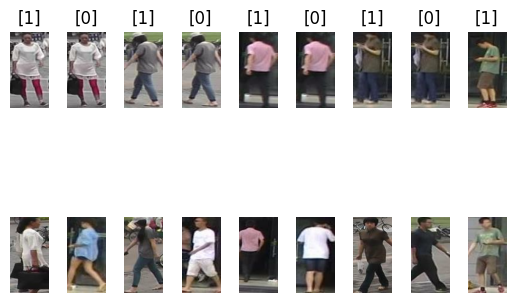

In [27]:
fig, axes = plt.subplots(2, 9)
plt.subplots_adjust(wspace=0.5, hspace=0)
j = 0

for img_1, img_2 in train_pair_x[:9]:
  axes[0, j].imshow(img_1)
  axes[1, j].imshow(img_2)
  axes[0, j].set_title(train_pair_y[j])
  axes[0, j].set_axis_off()
  axes[1, j].set_axis_off()
  j += 1

## Creating Siamese Network

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from utils.euclidian_distance import euclidean_distance

Choose a pretrained model

In [29]:
# the image size for all the images in The Market Dataset is 128x64
IMG_SHAPE = (128, 64, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
feature_extractor.trainable = False

In [30]:
feature_extractor.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 32, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 32, 32)   0           ['bn_Conv1[0][

Configure Siamese Network

In [31]:
print("[INFO] building model...")
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)

features_1 = feature_extractor(img_1)
features_2 = feature_extractor(img_2)
distance = Lambda(euclidean_distance)([features_1, features_2])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[img_1, img_2], outputs=outputs)   

[INFO] building model...


In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_7 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 4, 2, 1280)  2257984     ['input_6[0][0]',                
 al)                                                              'input_7[0][0]']          

## Training Siamese Network

In [35]:
BATCH_SIZE = 32
EPOCHS = 10

tensoboard_dir = "C:\Users\jands\Project_Shaman\Siamese Network\tensorboard_logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensoboard_dir, histogram_freq=1)

# compile the model
print("[INFO] compiling model...")
base_learning_rate = 0.0001
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pair_x[:, 0], train_pair_x[:, 1]], train_pair_y[:],
	validation_data=([val_pair_x[:, 0], val_pair_x[:, 1]], val_pair_y[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=[tensorboard_callback])

[INFO] compiling model...
[INFO] training model...
Epoch 1/10


ValueError: in user code:

    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\keras\backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1, 2, 1) vs (None, 1)).
